<a href="https://colab.research.google.com/github/kuanyshbakytuly/dataton/blob/main/fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import pandas as pd
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import random
def cv2_brightness_augment(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    seed = random.uniform(0.5,1.2)
    v = (( v/255.0 ) * seed)*255.0
    hsv[:,:,2] = np.array(np.clip(v,0,255),dtype=np.uint8)
    rgb_final = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return rgb_final


In [4]:
df = pd.read_csv("/train_labels.csv")
df.rename(columns = {'2418.jpg': 'image'}, inplace = True)
df.rename(columns = {'1': 'Y'}, inplace = True)
dicts = df.to_dict(orient="index")
print(dicts)
upd_dict = {}
for k, v in dicts.items():
  for k1, v1 in v.items():
    if len(k1) == 1:
      upd_dict[keys] = v1
    else:
      keys = v1
upd_dict["2418.jpg"] = 1

{0: {'image': '1482.jpg', 'Y': 1}, 1: {'image': '6152.jpg', 'Y': 1}, 2: {'image': '1099.jpg', 'Y': 1}, 3: {'image': '6164.jpg', 'Y': 1}, 4: {'image': '9113.jpg', 'Y': 1}, 5: {'image': '6522.jpg', 'Y': 1}, 6: {'image': '9496.jpg', 'Y': 1}, 7: {'image': '8903.jpg', 'Y': 1}, 8: {'image': '8680.jpg', 'Y': 1}, 9: {'image': '3138.jpg', 'Y': 1}, 10: {'image': '6175.jpg', 'Y': 1}, 11: {'image': '3895.jpg', 'Y': 1}, 12: {'image': '5234.jpg', 'Y': 1}, 13: {'image': '875.jpg', 'Y': 1}, 14: {'image': '8750.jpg', 'Y': 1}, 15: {'image': '9359.jpg', 'Y': 1}, 16: {'image': '1850.jpg', 'Y': 1}, 17: {'image': '8985.jpg', 'Y': 1}, 18: {'image': '3920.jpg', 'Y': 1}, 19: {'image': '8379.jpg', 'Y': 1}, 20: {'image': '7377.jpg', 'Y': 1}, 21: {'image': '4960.jpg', 'Y': 1}, 22: {'image': '3530.jpg', 'Y': 1}, 23: {'image': '2942.jpg', 'Y': 1}, 24: {'image': '9810.jpg', 'Y': 1}, 25: {'image': '1179.jpg', 'Y': 1}, 26: {'image': '7776.jpg', 'Y': 1}, 27: {'image': '6993.jpg', 'Y': 1}, 28: {'image': '9214.jpg', 'Y':

In [5]:
train_data = "/content/train_imgs"
valid_data = "/content/train_imgs"
test_data ="/content/test_imgs"
#our folder

In [6]:
from torch.utils.data import DataLoader, Dataset
class Train(Dataset):
    def __init__(self, folder, x1, x2):
        fpath =  glob(folder + '/*.jpg')
        self.fpaths = fpath[x1: x2]
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        self.targets = [upd_dict[fpath.split('/')[-1]] for fpath in self.fpaths]

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = self.image_segmentation(im)
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

    def image_segmentation(self, image):
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower_hsv = np.array([0,0,250])
        upper_hsv = np.array([250,255,255])
    
        mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        output = cv2.bitwise_and(image, image, mask = mask) / 255
        image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
        image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
        return image_sharp

In [7]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

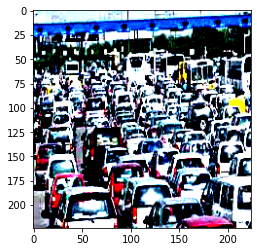

In [8]:
train_data = "/content/train_imgs"
valid_data = "/content/train_imgs"
test_2data ="/content/test_imgs"
data = Train(train_data, 0, 200)
im, _ = data[0]
plt.imshow(im.permute(1,2,0).cpu())
#our folder

In [9]:
def get_data():
    train = Train(train_data, 0, 1000)
    trn_dl = DataLoader(train, batch_size=16, shuffle=True, drop_last = True)
    val = Train(valid_data, 1100, 1200)
    val_dl = DataLoader(val, batch_size=16, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [10]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [11]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
print(dir(trn_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_get_shared_seed', '_index_sampler', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']


In [13]:
from copy import deepcopy
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(10):
    print(f" epoch {epoch + 1}/10")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)


 epoch 1/10
 epoch 2/10
 epoch 3/10
 epoch 4/10
 epoch 5/10
 epoch 6/10
 epoch 7/10
 epoch 8/10
 epoch 9/10
 epoch 10/10


In [14]:
print(sum(train_accuracies)/10)
print(sum(val_accuracies)/10)

0.9772177419354838
0.9614583333333334


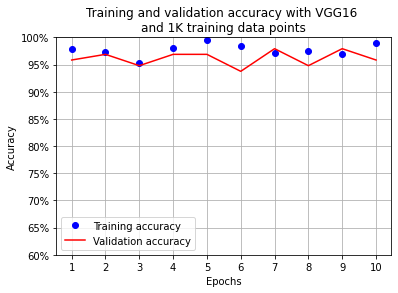

In [16]:
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.6,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset
class testing(Dataset):
    def __init__(self, folder):
        self.fpaths  =  glob(folder + '/*.jpg')[:10]

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]  # №ix jpg
        im = (cv2.imread(f)[:, :, ::-1])  # as cv2 reads images as BGR, we need to conver to RGB
        im = cv2.resize(im, (224, 224))  # resixe 224 X 224
        #
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), f

    def collate_fn(self, batch):
        ims, f = list(zip(*batch))
        # transform a batch of images at once
        if self.aug: ims=self.aug.augment_images(images=ims)
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        return ims

In [ ]:
def get_data():     
    data_ne = testing(test_data)
    test = DataLoader(data_ne, batch_size=len(data_ne), shuffle=True, drop_last = True)
    return test

In [ ]:
fpas = {}
test = get_data()
model.eval()
for ix, batch in enumerate(iter(test)):
  x, y =batch
  isn = model(x)
  fpas[y] = isn
print(fpas)

In [ ]:
print(isn)

In [ ]:
a = dict(zip(list(fpas.keys())[0], list(fpas.values())[0]))

In [ ]:
for value in a:
  im = (cv2.imread(value)[:, :, ::-1])
  im = cv2.resize(im, (224, 224))  # resixe 224 X 224
        #
  im = torch.tensor(im / 255).permute(2, 0, 1).to(device).float()
  plt.imshow(im.permute(1,2,0).cpu())
  plt.title(a[value])
  plt.show()